#### Import Libraries and Data

In [20]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# import cleaned Dataframes from Data preparation
charging_data = pd.read_pickle(os.path.join('Data', 'charging_data.pkl'))
weather_data = pd.read_pickle(os.path.join('Data', 'weather_data.pkl'))
merged_data = pd.read_pickle(os.path.join('Data', 'merged_charging_weather_data.pkl'))

## Task 2: Descriptive Analytics

### a) Temporal Patterns and Seasonality

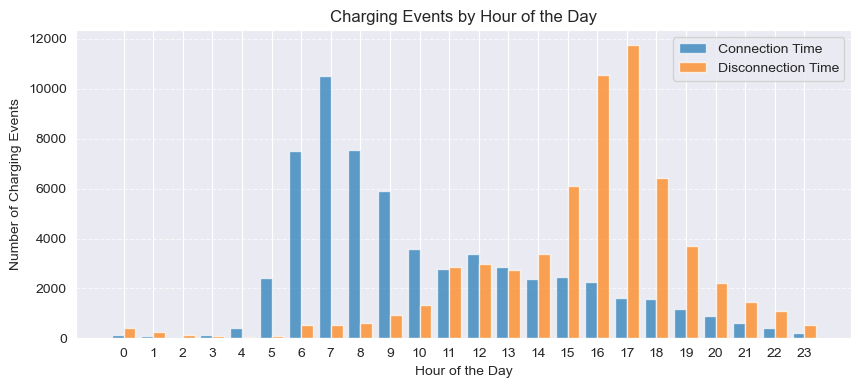

In [21]:
# Extract the hour from 'connectionTime' and 'disconnectTime'
charging_data['connection_hour'] = charging_data['connectionTime'].dt.hour
charging_data['disconnect_hour'] = charging_data['disconnectTime'].dt.hour

# Group by hour and count the number of sessions for both connection and disconnection
connection_hourly_sessions = charging_data.groupby('connection_hour').size()
disconnect_hourly_sessions = charging_data.groupby('disconnect_hour').size()

# Align indexes for plotting
hours = np.arange(0, 24)

# Ensure all hours are present for alignment (fill missing hours with 0)
# Without this step missing hours would not be displayed on the x-axis
connection_hourly_sessions = connection_hourly_sessions.reindex(hours, fill_value=0)
disconnect_hourly_sessions = disconnect_hourly_sessions.reindex(hours, fill_value=0)

# Plot the bar chart
plt.figure(figsize=(10, 4))
plt.bar(hours - 0.2, connection_hourly_sessions, width=0.4, label='Connection Time', alpha=0.7)
plt.bar(hours + 0.2, disconnect_hourly_sessions, width=0.4, label='Disconnection Time', alpha=0.7)

plt.title('Charging Events by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Charging Events')
plt.xticks(hours)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The chart shows the distribution of charging events of both sites across different hours of the day. </br>
Observations: </br>
- Noticeable peak of the connectionTime during the morning (SOB - start of business) and peak of disconnectTime during the afternoon (EOB - end of business)
- Low Activity during late-night hours

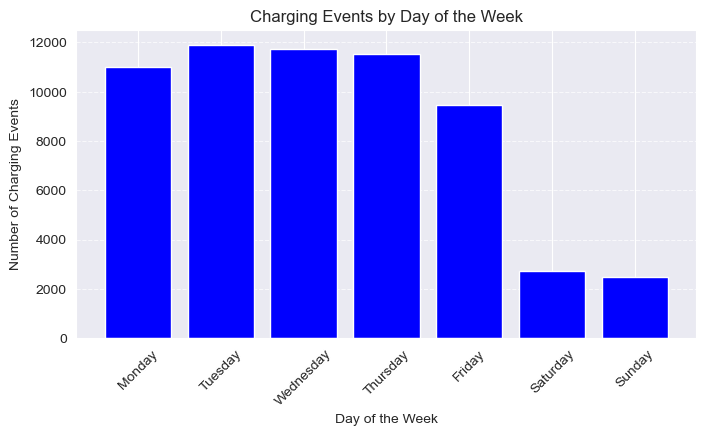

In [22]:
# Extract the day of the week from 'connectionTime'
charging_data['weekday'] = charging_data['connectionTime'].dt.day_name()

# Group by weekday and count the number of charging sessions
weekday_sessions = charging_data.groupby('weekday').size()

# Order the days of the week for better visualization
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sessions = weekday_sessions.reindex(ordered_days)

# Plot the number of sessions by day of the week
plt.figure(figsize=(8, 4))
plt.bar(weekday_sessions.index, weekday_sessions.values, color='blue')
plt.title('Charging Events by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Charging Events')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The chart shows the distribution of charging events of both sites across the days of the week. </br>
Observation: Strong weekday and weaker weekend activity, indicating work- & university-related pattern

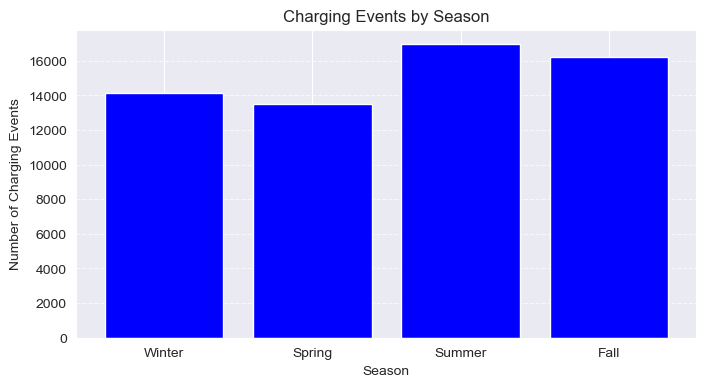

In [23]:
# Visualize seasonality over both sites
# Define a function to map months to seasons
def map_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Map the 'connectionTime' to seasons
charging_data['season'] = charging_data['connectionTime'].dt.month.map(map_season)

# Group by season and count the number of charging sessions
seasonal_sessions = charging_data.groupby('season').size()

# Order the seasons for visualization
ordered_seasons = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_sessions = seasonal_sessions.reindex(ordered_seasons)

# Plot the number of sessions by season
plt.figure(figsize=(8, 4))
plt.bar(seasonal_sessions.index, seasonal_sessions.values, color='blue')
plt.title('Charging Events by Season')
plt.xlabel('Season')
plt.ylabel('Number of Charging Events')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The chart shows the distribution of charging events of both sites across different seasons (winter, spring, summer, fall). </br>
We have to keep in mind, that between 3rd August 2020 and 18th November 2020 are no records in the charging dataset, which leads to the assumption that there would be even more charging events in summer and fall. </br>
Observations: </br>
- Winter: Fewer outdoor activities could result in lower public charging demand
- Summer: Higher EV usage for outdoor activities may lead to increased charging demand

### Weather-dependant analysis

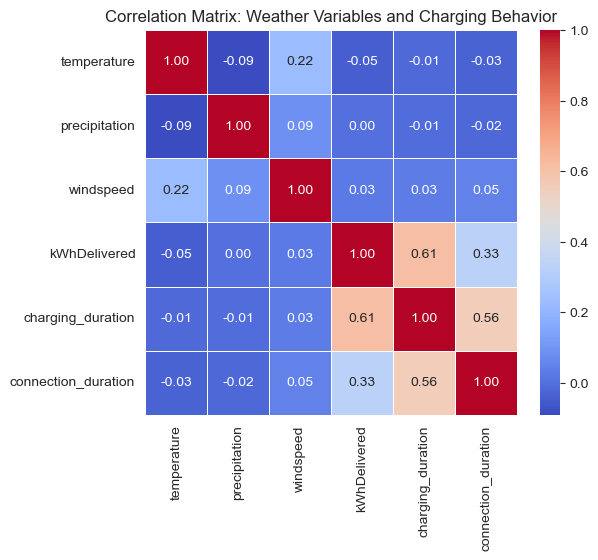

In [24]:
# Select relevant columns for correlation
correlation_data = merged_data[['temperature', 'precipitation', 'windspeed', 'kWhDelivered', 'charging_duration', 'connection_duration']]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix: Weather Variables and Charging Behavior')
plt.show()

# Extract specific correlations
temp_energy_corr = correlation_matrix.loc['temperature', 'kWhDelivered']
precip_duration_corr = correlation_matrix.loc['precipitation', 'charging_duration']
wind_connection_corr = correlation_matrix.loc['windspeed', 'connection_duration']

Observations from the Correlation Matrix: </br>
- Minimal impact of weather variables: temperature, precipitation and wind speed have minimal influence on energy delivered, charging duration and connection duration
- The most significant relationships are within the charging behavior metric themselves: charging duration and kWhDelivered increase as the connection duration increases, as expected

## 3. Cluster Analysis

In [25]:
charging_data.head()

,counter,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,...,userID,userInputs,connection_date,year_month,charging_duration,connection_duration,connection_hour,disconnect_hour,weekday,season
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 05:08:54-08:00,2020-01-02 11:11:15-08:00,2020-01-02 09:31:35-08:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,...,194,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil...",2020-01-02,2020-01,262.683333,362.350000,5,11,Thursday,Winter
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 05:36:50-08:00,2020-01-02 14:38:21-08:00,2020-01-02 12:18:05-08:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,...,4275,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil...",2020-01-02,2020-01,401.250000,541.516667,5,14,Thursday,Winter
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 05:56:35-08:00,2020-01-02 16:39:22-08:00,2020-01-02 08:35:06-08:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,...,344,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",2020-01-02,2020-01,158.516667,642.783333,5,16,Thursday,Winter
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 05:59:58-08:00,2020-01-02 08:38:39-08:00,2020-01-02 07:18:45-08:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,...,1117,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",2020-01-02,2020-01,78.783333,158.683333,5,8,Thursday,Winter
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 06:00:01-08:00,2020-01-02 14:08:40-08:00,2020-01-02 10:17:30-08:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,...,334,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil...",2020-01-02,2020-01,257.483333,488.650000,6,14,Thursday,Winter


In [26]:
charging_data['User'] = charging_data['userID'].apply(lambda x: 'Unregistered' if x == '' else 'Registered')
charging_data[['userID', 'User']]

,userID,User
0,194,Registered
1,4275,Registered
2,344,Registered
3,1117,Registered
4,334,Registered
...,...,...
65032,1346,Registered
65033,364,Registered
65034,2050,Registered
65035,1626,Registered


### 3.1 Usage Intensity and Duration

#### `kWhDelivered` and `connection_duration`

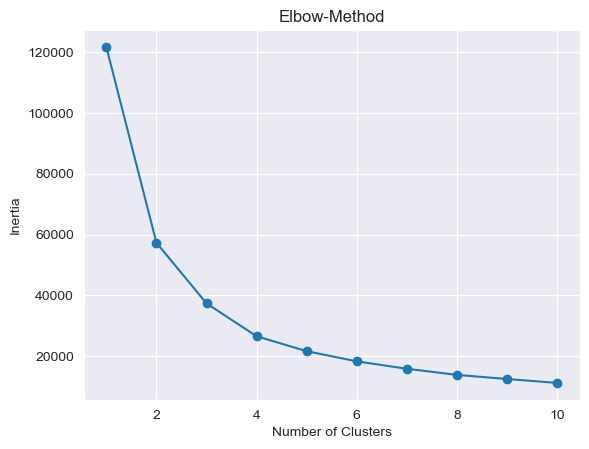

In [48]:
# Select relevant features for the cluster analysis and scale them
scaler = StandardScaler()
charging_data_cluster_1 = charging_data
charging_data_cluster_1[['kWhDelivered_T', 'connection_duration_T']] = scaler.fit_transform(charging_data_cluster_1[['kWhDelivered', 'connection_duration']])

inertia_1 = [] # Measure of how well the data was clustered by the k-means algorithm (sum of squared distances to the nearest cluster center)
# As the number of clusters increases the inertia will decrease
for k in range(1, 11): # Testing k values from 1 to 10
    kmeans_1 = KMeans(n_clusters=k, random_state=42) # setting random_state=42 ensures that the results of the algorithm are reproducible
    kmeans_1.fit(charging_data_cluster_1[['kWhDelivered_T', 'connection_duration_T']])
    #kmeans_1.fit(charging_data_cluster_1[['kWhDelivered_T', 'connection_duration_T', 'connection_hour']])
    #kmeans_1.fit(charging_data_cluster_1[['kWhDelivered_T', 'connection_duration_T', 'disconnect_hour']])
    #kmeans_1.fit(charging_data_cluster_1[['kWhDelivered_T', 'connection_duration_T', 'connection_hour', 'disconnect_hour']])
    inertia_1.append(kmeans_1.inertia_)

# Elbow-Plot
plt.plot(range(1, 11), inertia_1, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow-Method')
plt.show()

In [28]:
# Features und weitere Informationen in ein DF bringen
# 3d Scatter Plot ausprobieren
# PCA anwenden und interpretieren
# Weitere Clustermöglichkeiten überlegen -> Zeitlich nach z. B. connectionTime ?
# DBSCAN anwenden

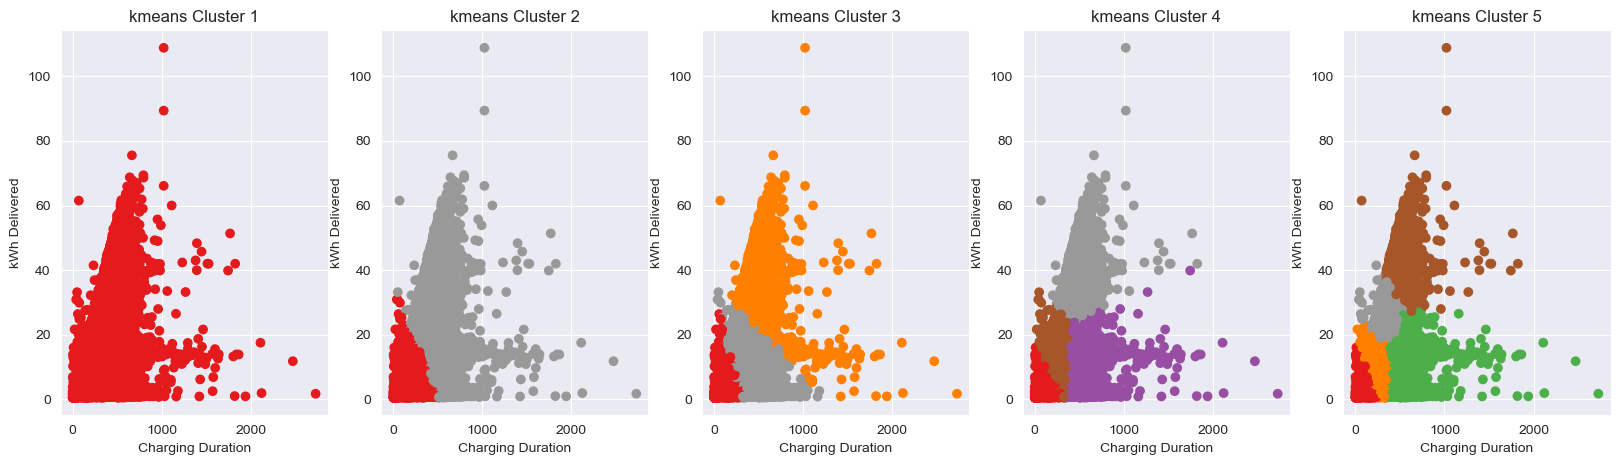

In [49]:
# Creating multiple clusters
for k in range(1, 6):
    kmeans_1 = KMeans(n_clusters=k, random_state=42)
    charging_data_cluster_1[f'kmeans_{k}'] = kmeans_1.fit_predict(charging_data_cluster_1[['kWhDelivered_T', 'connection_duration_T']])
    #charging_data_cluster_1[f'kmeans_{k}'] = kmeans_1.fit_predict(charging_data_cluster_1[['kWhDelivered_T', 'connection_duration_T', 'connection_hour']])
    #charging_data_cluster_1[f'kmeans_{k}'] = kmeans_1.fit_predict(charging_data_cluster_1[['kWhDelivered_T', 'connection_duration_T', 'disconnect_hour']])
    #charging_data_cluster_1[f'kmeans_{k}'] = kmeans_1.fit_predict(charging_data_cluster_1[['kWhDelivered_T', 'connection_duration_T', 'connection_hour', 'disconnect_hour']])

# Creating multiple scatter plots for different kmeans clusters
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=charging_data_cluster_1['connection_duration'], y=charging_data_cluster_1['kWhDelivered'], c=charging_data_cluster_1[f'kmeans_{i}'], cmap='Set1')
    ax.set_title(f'kmeans Cluster {i}')
    ax.set_xlabel('Connecntion Duration')
    ax.set_ylabel('kWh Delivered')

In [30]:
# Display cluster summaries for kmeans Cluster 1-5
cluster_summaries = {}
for k in range(1, 6):
    cluster_column = f'kmeans_{k}'  # Column name for the current KMeans clustering
    if cluster_column in charging_data_cluster_1.columns:
        # Group by cluster and calculate mean for relevant features
        summary = charging_data_cluster_1.groupby(cluster_column)[['kWhDelivered', 'charging_duration', 'connection_duration']].mean()
        # Add cluster sizes
        summary['Cluster Size'] = charging_data_cluster_1[cluster_column].value_counts()
        cluster_summaries[k] = summary

# Display summaries for each KMeans configuration
for k, summary in cluster_summaries.items():
    print(f"\nSummary for KMeans (k={k}):")
    print(summary)


Summary for KMeans (k=1):
          kWhDelivered  charging_duration  connection_duration  Cluster Size
kmeans_1                                                                    
0            11.587633         209.750077           376.334457         60834

Summary for KMeans (k=2):
          kWhDelivered  charging_duration  connection_duration  Cluster Size
kmeans_2                                                                    
0             7.651918         142.727947           327.157668         46275
1            24.097090         422.776318           532.640242         14559

Summary for KMeans (k=3):
          kWhDelivered  charging_duration  connection_duration  Cluster Size
kmeans_3                                                                    
0             6.290592         109.314257           294.260229         35784
1            36.269389         468.563708           572.113504          5712
2            14.099119         319.153940           470.380081         1

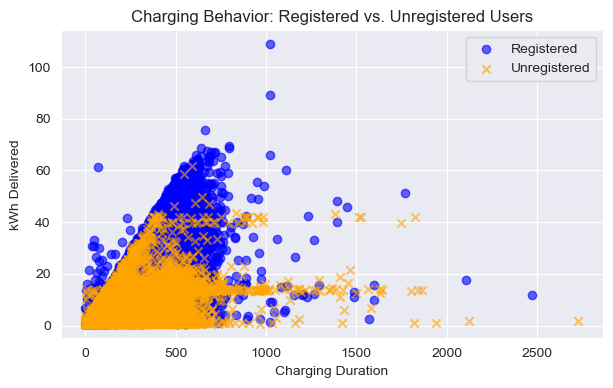

In [31]:
# Separate the data into registered and unregistered users
registered_users = charging_data_cluster_1[charging_data_cluster_1['User'] == 'Registered']
unregistered_users = charging_data_cluster_1[charging_data_cluster_1['User'] == 'Unregistered']

# Create the scatter plot
plt.figure(figsize=(7, 4))
plt.scatter(x=registered_users['charging_duration'], y=registered_users['kWhDelivered'], c='blue', label='Registered', alpha=0.6, marker='o')
plt.scatter(x=unregistered_users['charging_duration'], y=unregistered_users['kWhDelivered'], c='orange', label='Unregistered', alpha=0.6, marker='x')

plt.title('Charging Behavior: Registered vs. Unregistered Users')
plt.xlabel('Charging Duration')
plt.ylabel('kWh Delivered')
plt.legend()
plt.grid(True)
plt.show()

#### `kWhDelivered` and `connection_duration`

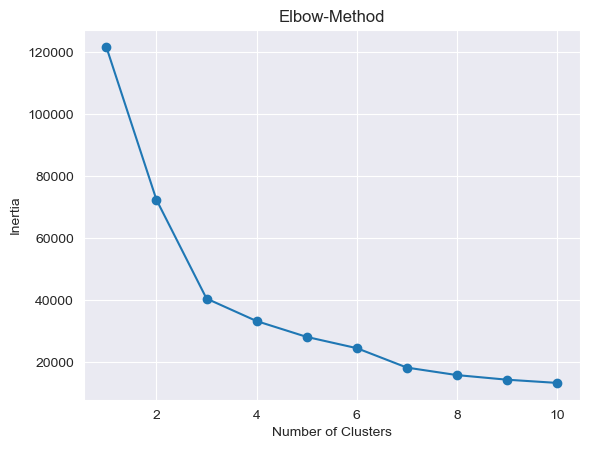

In [32]:
# Select relevant features for the cluster analysis and scale them
scaler = StandardScaler()
charging_data_cluster_2 = charging_data
charging_data_cluster_2[['kWhDelivered_T', 'connection_duration_T']] = scaler.fit_transform(charging_data_cluster_2[['kWhDelivered', 'connection_duration']])

inertia_2 = [] # Measure of how well the data was clustered by the k-means algorithm (sum of squared distances to the nearest cluster center)
# As the number of clusters increases the inertia will decrease
for k in range(1, 11): # Testing k values from 1 to 10
    kmeans_2 = KMeans(n_clusters=k, random_state=42) # setting random_state=42 ensures that the results of the algorithm are reproducible
    kmeans_2.fit(charging_data_cluster_2[['kWhDelivered_T', 'connection_duration_T']])
    inertia_2.append(kmeans_2.inertia_)

# Elbow-Plot
plt.plot(range(1, 11), inertia_2, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow-Method')
plt.show()

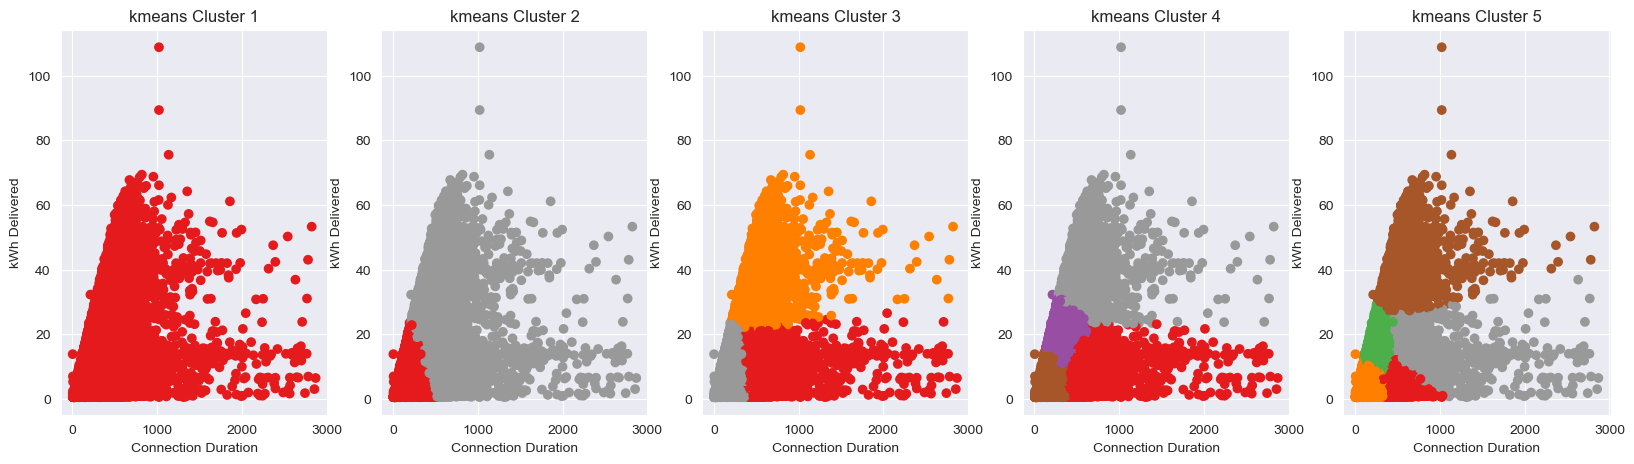

In [33]:
# Creating multiple clusters
for k in range(1, 6):
    kmeans_2 = KMeans(n_clusters=k, random_state=42)
    charging_data_cluster_2[f'kmeans_{k}'] = kmeans_2.fit_predict(charging_data_cluster_2[['kWhDelivered_T', 'connection_duration_T']])

# Creating multiple scatter plots for different kmeans clusters
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=charging_data_cluster_2['connection_duration'], y=charging_data_cluster_2['kWhDelivered'], c=charging_data_cluster_2[f'kmeans_{i}'], cmap='Set1')
    ax.set_title(f'kmeans Cluster {i}')
    ax.set_xlabel('Connection Duration')
    ax.set_ylabel('kWh Delivered')

#### `charging_duration` and `connection_duration`

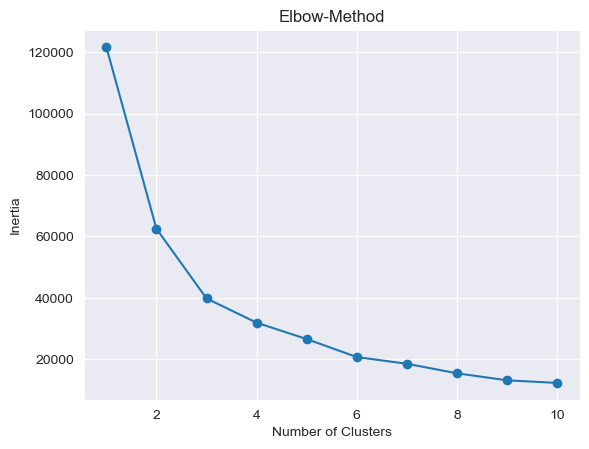

In [34]:
# Select relevant features for the cluster analysis and scale them
scaler = StandardScaler()
charging_data_cluster_3 = charging_data
charging_data_cluster_3[['charging_duration_T', 'connection_duration_T']] = scaler.fit_transform(charging_data_cluster_3[['charging_duration', 'connection_duration']])

inertia_3 = [] # Measure of how well the data was clustered by the k-means algorithm (sum of squared distances to the nearest cluster center)
# As the number of clusters increases the inertia will decrease
for k in range(1, 11): # Testing k values from 1 to 10
    kmeans_3 = KMeans(n_clusters=k, random_state=42) # setting random_state=42 ensures that the results of the algorithm are reproducible
    kmeans_3.fit(charging_data_cluster_3[['charging_duration_T', 'connection_duration_T']])
    inertia_3.append(kmeans_3.inertia_)

# Elbow-Plot
plt.plot(range(1, 11), inertia_3, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow-Method')
plt.show()

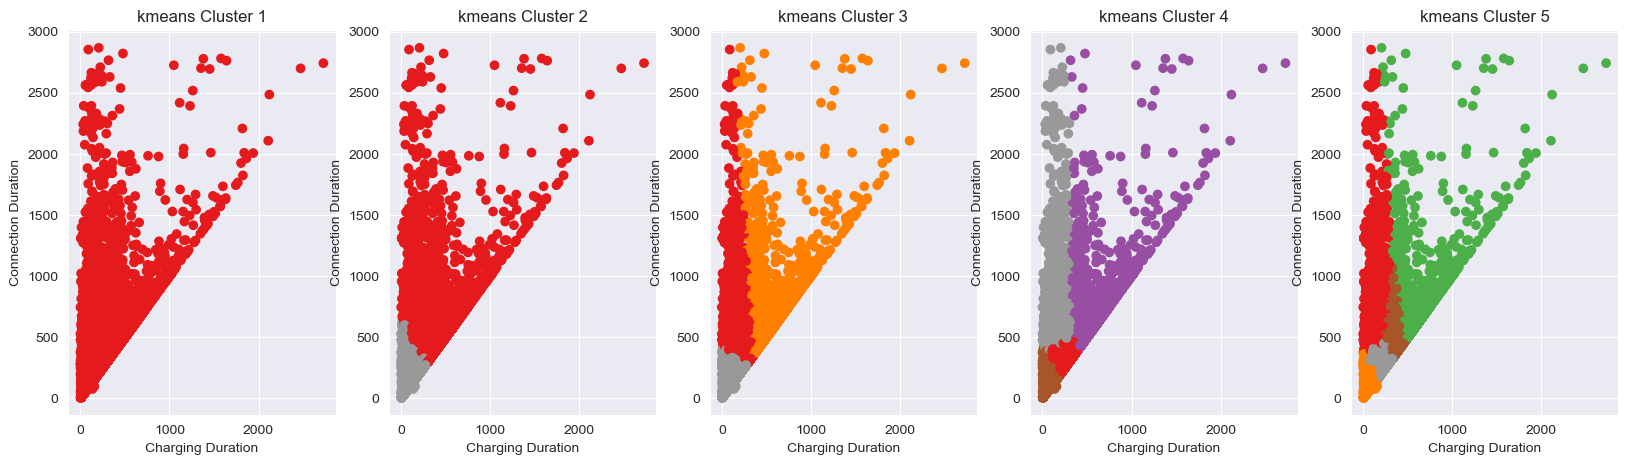

In [35]:
# Creating multiple clusters
for k in range(1, 6):
    kmeans_3 = KMeans(n_clusters=k, random_state=42)
    charging_data_cluster_3[f'kmeans_{k}'] = kmeans_3.fit_predict(charging_data_cluster_3[['charging_duration_T', 'connection_duration_T']])

# Creating multiple scatter plots for different kmeans clusters
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=charging_data_cluster_3['charging_duration'], y=charging_data_cluster_3['connection_duration'], c=charging_data_cluster_3[f'kmeans_{i}'], cmap='Set1')
    ax.set_title(f'kmeans Cluster {i}')
    ax.set_xlabel('Charging Duration')
    ax.set_ylabel('Connection Duration')

Woher kommt der diagonale Schnitt? => Die Charging Duration kann nicht länger sein, als die Connection Duration, daher ergibt sich ein diagonaler Schnitt

## 3.2 Temporal Pattern

#### Hour of the Day from `connectionTime` and `charging_duration`

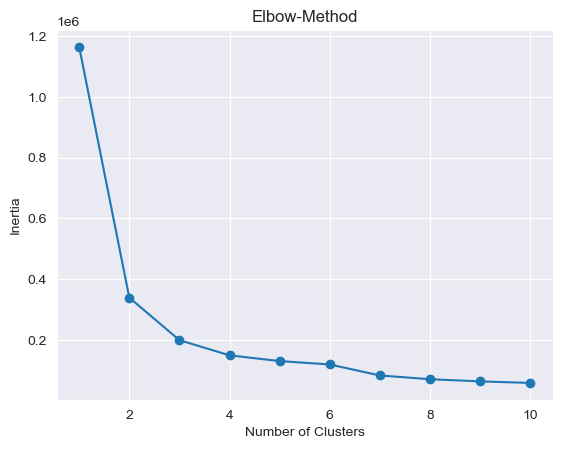

In [36]:
# Select relevant features for the cluster analysis and scale them
scaler = StandardScaler()
charging_data_cluster_4 = charging_data
charging_data_cluster_4[['charging_duration_T', 'connection_duration_T']] = scaler.fit_transform(charging_data_cluster_4[['charging_duration', 'connection_duration']])

inertia_4 = [] # Measure of how well the data was clustered by the k-means algorithm (sum of squared distances to the nearest cluster center)
# As the number of clusters increases the inertia will decrease
for k in range(1, 11): # Testing k values from 1 to 10
    kmeans_4 = KMeans(n_clusters=k, random_state=42) # setting random_state=42 ensures that the results of the algorithm are reproducible
    kmeans_4.fit(charging_data_cluster_4[['connection_hour', 'charging_duration_T']])
    inertia_4.append(kmeans_4.inertia_)

# Elbow-Plot
plt.plot(range(1, 11), inertia_4, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow-Method')
plt.show()

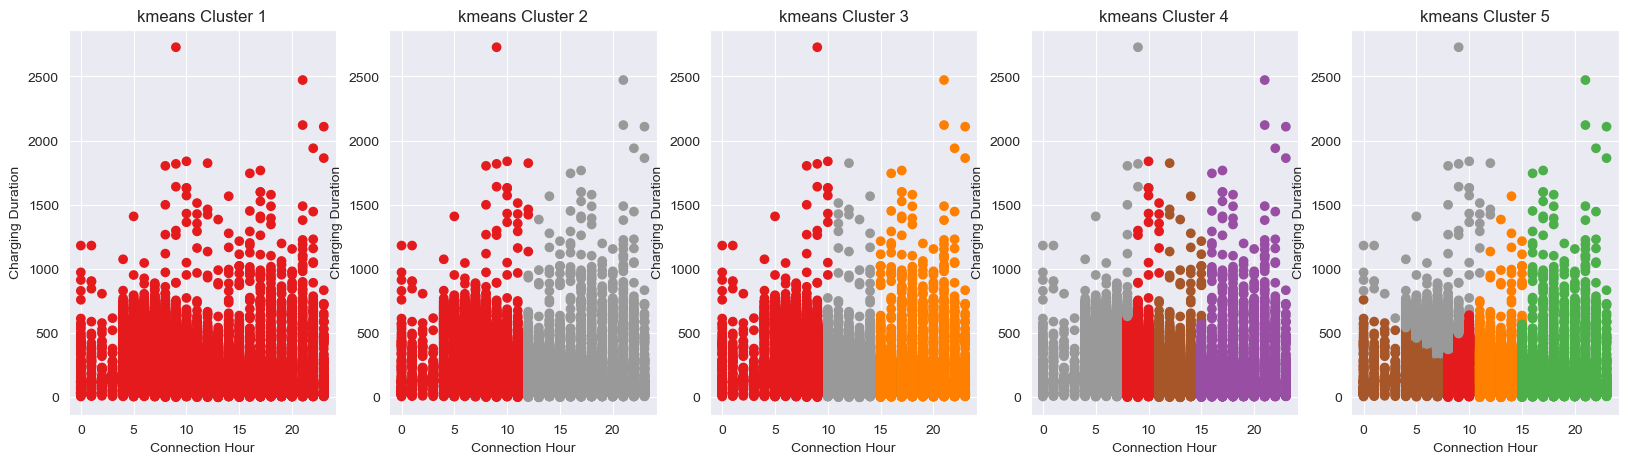

In [37]:
# Creating multiple clusters
for k in range(1, 6):
    kmeans_4 = KMeans(n_clusters=k, random_state=42)
    charging_data_cluster_4[f'kmeans_{k}'] = kmeans_4.fit_predict(charging_data_cluster_4[['connection_hour', 'charging_duration_T']])

# Creating multiple scatter plots for different kmeans clusters
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=charging_data_cluster_4['connection_hour'], y=charging_data_cluster_4['charging_duration'], c=charging_data_cluster_4[f'kmeans_{i}'], cmap='Set1')
    ax.set_title(f'kmeans Cluster {i}')
    ax.set_xlabel('Connection Hour')
    ax.set_ylabel('Charging Duration')

### DBSCAN

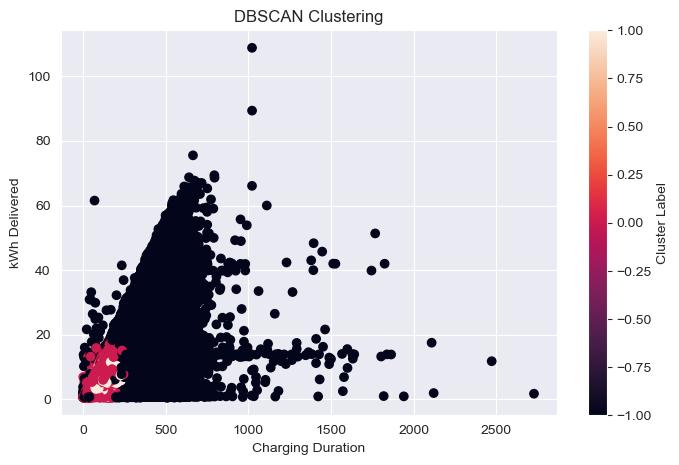

In [38]:
# Select relevant features for the cluster analysis and scale them
scaler = StandardScaler()
charging_data_cluster_dbscan = charging_data
charging_data_cluster_dbscan[['kWhDelivered_T', 'charging_duration_T', 'connection_duration_T']] = scaler.fit_transform(charging_data_cluster_dbscan[['kWhDelivered', 'charging_duration', 'connection_duration']])

dbscan = DBSCAN(eps=0.5, min_samples=5000)
dbscan_labels = dbscan.fit_predict(charging_data_cluster_dbscan[['kWhDelivered_T', 'charging_duration_T', 'connection_duration_T']])

charging_data_cluster_dbscan['dbscan_labels'] = dbscan_labels

plt.figure(figsize=(8, 5))
plt.scatter(charging_data_cluster_dbscan['charging_duration'], charging_data_cluster_dbscan['kWhDelivered'], c=charging_data_cluster_dbscan['dbscan_labels'])
plt.title('DBSCAN Clustering')
plt.xlabel('Charging Duration')
plt.ylabel('kWh Delivered')
plt.colorbar(label='Cluster Label')
plt.show()